# Token Norm Evolution Through Layers

**Date:** October 29, 2025

**Goal:** Analyze how individual token representations evolve geometrically through the transformer.

**Question:** Does manifold expansion affect all tokens uniformly, or do different tokens/positions experience different geometric transformations?

**Method:**
1. Load token activations from 08.1 ([36, n_tokens, 2560])
2. Compute causal norm ||activation||_M for each token at each layer → [36, n_tokens]
3. Compute Δs = norm[layer+1] - norm[layer] → [35, n_tokens]
4. Visualize:
   - Heatmap: norms across layers and tokens
   - Heatmap: Δs (growth rate)
   - Line plots: mean ± std of norms and Δs by layer
   - Sample trajectories: individual tokens' norm evolution
   - Distribution: Δs variability by layer

**Hypothesis:** If expansion is uniform, Δs will have low variance and smooth gradients. If heterogeneous, we'll see stripes, bands, or high variability.

## Setup

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
ACTIVATIONS_PATH = '../data/results/token_activations_sample.pt'
METRIC_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

print("Configuration:")
print(f"  Activations: {ACTIVATIONS_PATH}")
print(f"  Metric tensor: {METRIC_PATH}")

Configuration:
  Activations: ../data/results/token_activations_sample.pt
  Metric tensor: ../data/vectors/causal_metric_tensor_qwen3_4b.pt


## Load Data

In [22]:
print("Loading activations...")
act_data = torch.load(ACTIVATIONS_PATH, weights_only=False)
activations = act_data['activations']  # [n_layers, n_tokens, hidden_dim]

n_layers, n_tokens, hidden_dim = activations.shape
print(f"✓ Loaded activations: {activations.shape}")
print(f"  {n_layers} layers, {n_tokens} tokens, {hidden_dim} dimensions")
print(f"  Dtype: {activations.dtype}")

print("\nLoading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, weights_only=False)
M = metric_data['M']  # [hidden_dim, hidden_dim]
print(f"✓ Loaded metric tensor: {M.shape}")
print(f"  Dtype: {M.dtype}")

# Ensure both tensors are on CPU and same dtype (float32)
activations = activations.cpu().float()
M = M.cpu().float()

print(f"\n✓ Converted to matching dtype and device:")
print(f"  Activations: {activations.dtype} on {activations.device}")
print(f"  Metric: {M.dtype} on {M.device}")

Loading activations...
✓ Loaded activations: torch.Size([36, 512, 2560])
  36 layers, 512 tokens, 2560 dimensions
  Dtype: torch.bfloat16

Loading causal metric tensor...
✓ Loaded metric tensor: torch.Size([2560, 2560])
  Dtype: torch.float32

✓ Converted to matching dtype and device:
  Activations: torch.float32 on cpu
  Metric: torch.float32 on cpu


## Compute Causal Norms

For each token at each layer, compute ||activation||_M = √(activation^T M activation)

In [23]:
print("Computing causal norms for all tokens at all layers...")

# Initialize storage
causal_norms = np.zeros((n_layers, n_tokens))

# Compute norms layer by layer (to avoid huge memory allocations)
for layer_idx in range(n_layers):
    if layer_idx % 10 == 0:
        print(f"  Processing layer {layer_idx}/{n_layers}...")
    
    # Get activations for this layer: [n_tokens, hidden_dim]
    layer_activations = activations[layer_idx]  # [n_tokens, hidden_dim]
    
    # Compute norms for all tokens at once: ||v||_M = sqrt(v^T M v)
    # For multiple vectors: [n_tokens, hidden_dim] @ [hidden_dim, hidden_dim] @ [hidden_dim, n_tokens]
    # = [n_tokens, hidden_dim] @ [hidden_dim, n_tokens] = [n_tokens, n_tokens] diagonal
    norms_squared = torch.sum(layer_activations @ M * layer_activations, dim=1)  # [n_tokens]
    norms = torch.sqrt(norms_squared)
    
    causal_norms[layer_idx] = norms.numpy()

print(f"✓ Computed causal norms: {causal_norms.shape}")
print(f"  Range: [{causal_norms.min():.1f}, {causal_norms.max():.1f}] logometers")
print(f"  Mean: {causal_norms.mean():.1f} ± {causal_norms.std():.1f} logometers")

Computing causal norms for all tokens at all layers...
  Processing layer 0/36...
  Processing layer 10/36...
  Processing layer 20/36...
  Processing layer 30/36...
✓ Computed causal norms: (36, 512)
  Range: [303.9, 241483.1] logometers
  Mean: 9866.2 ± 15046.5 logometers


## Compute Growth Rate (Δs)

For each layer transition, compute Δs = norm[layer+1] - norm[layer]

In [24]:
print("Computing Δs (change in norm between consecutive layers)...")

# Δs[i, j] = causal_norms[i+1, j] - causal_norms[i, j]
delta_norms = np.diff(causal_norms, axis=0)  # [n_layers-1, n_tokens]

print(f"✓ Computed Δs: {delta_norms.shape}")
print(f"  Range: [{delta_norms.min():.1f}, {delta_norms.max():.1f}] logometers/layer")
print(f"  Mean: {delta_norms.mean():.1f} ± {delta_norms.std():.1f} logometers/layer")

# Check for monotonicity
negative_deltas = (delta_norms < 0).sum()
total_deltas = delta_norms.size
print(f"\nMonotonicity check:")
print(f"  Negative Δs: {negative_deltas:,} / {total_deltas:,} ({100*negative_deltas/total_deltas:.1f}%)")
if negative_deltas / total_deltas < 0.1:
    print(f"  → Norms are MOSTLY MONOTONICALLY INCREASING")
elif negative_deltas / total_deltas > 0.4:
    print(f"  → Many tokens SHRINK in causal norm during processing")
else:
    print(f"  → Mixed behavior: some tokens grow, some shrink")

Computing Δs (change in norm between consecutive layers)...
✓ Computed Δs: (35, 512)
  Range: [-161127.1, 225778.0] logometers/layer
  Mean: 1052.8 ± 3452.2 logometers/layer

Monotonicity check:
  Negative Δs: 1,487 / 17,920 (8.3%)
  → Norms are MOSTLY MONOTONICALLY INCREASING


## Visualization 1: Heatmap of Causal Norms

**X-axis:** Token position  
**Y-axis:** Layer  
**Color:** Causal norm magnitude

**What to look for:**
- Smooth gradient top-to-bottom → uniform expansion
- Vertical stripes → position-dependent effects
- Horizontal bands → layer-specific phase transitions

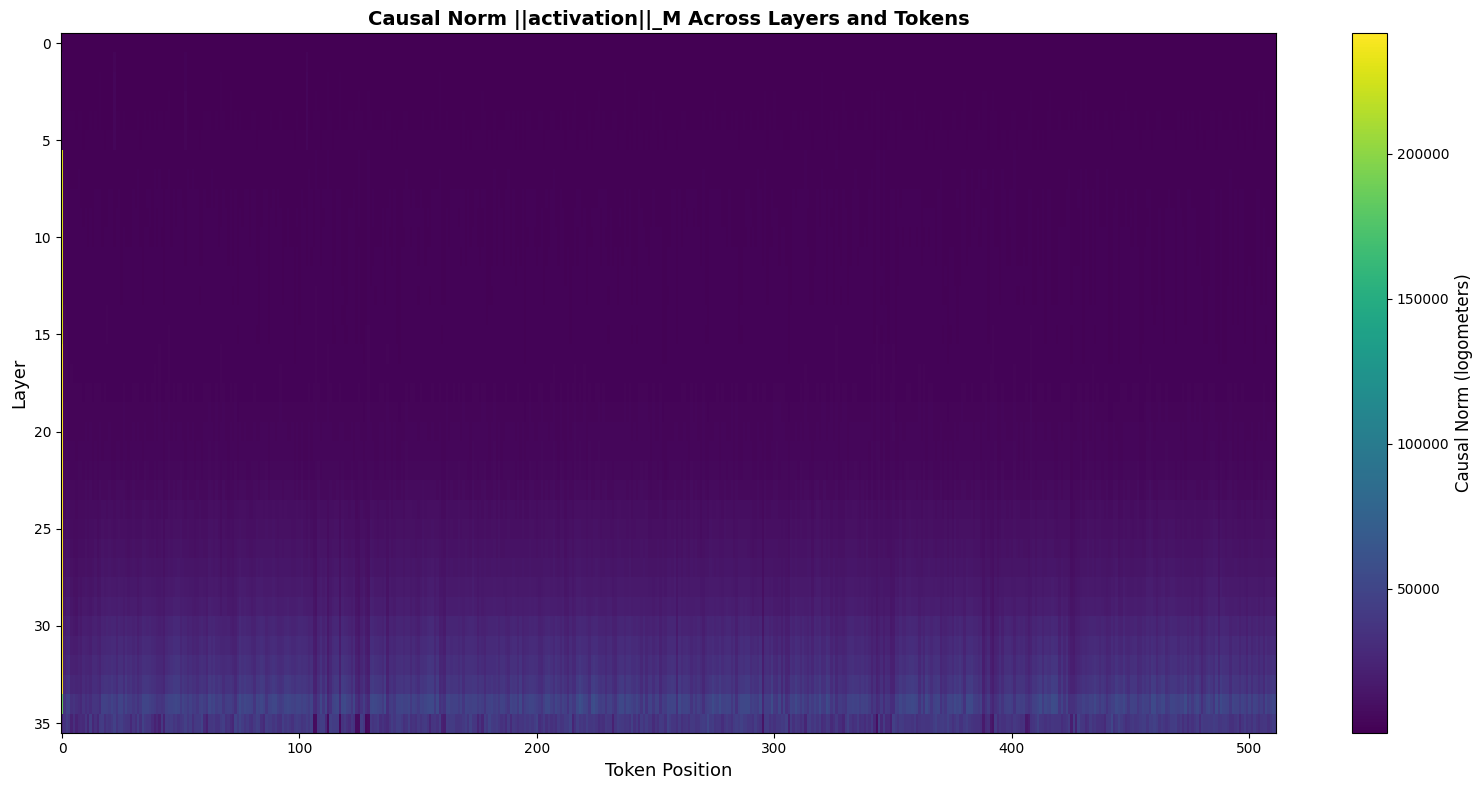

In [25]:
fig, ax = plt.subplots(figsize=(16, 8))

im = ax.imshow(
    causal_norms,
    aspect='auto',
    cmap='viridis',
    interpolation='nearest',
)

ax.set_xlabel('Token Position', fontsize=13)
ax.set_ylabel('Layer', fontsize=13)
ax.set_title('Causal Norm ||activation||_M Across Layers and Tokens', fontsize=14, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Causal Norm (logometers)', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization 2: Heatmap of Δs (Growth Rate)

**X-axis:** Token position  
**Y-axis:** Layer transition (0→1, 1→2, ..., 34→35)  
**Color:** Δs magnitude

**What to look for:**
- Uniform color → all tokens grow at same rate
- Speckled pattern → noisy, token-specific growth
- Horizontal bands → specific layers cause big jumps

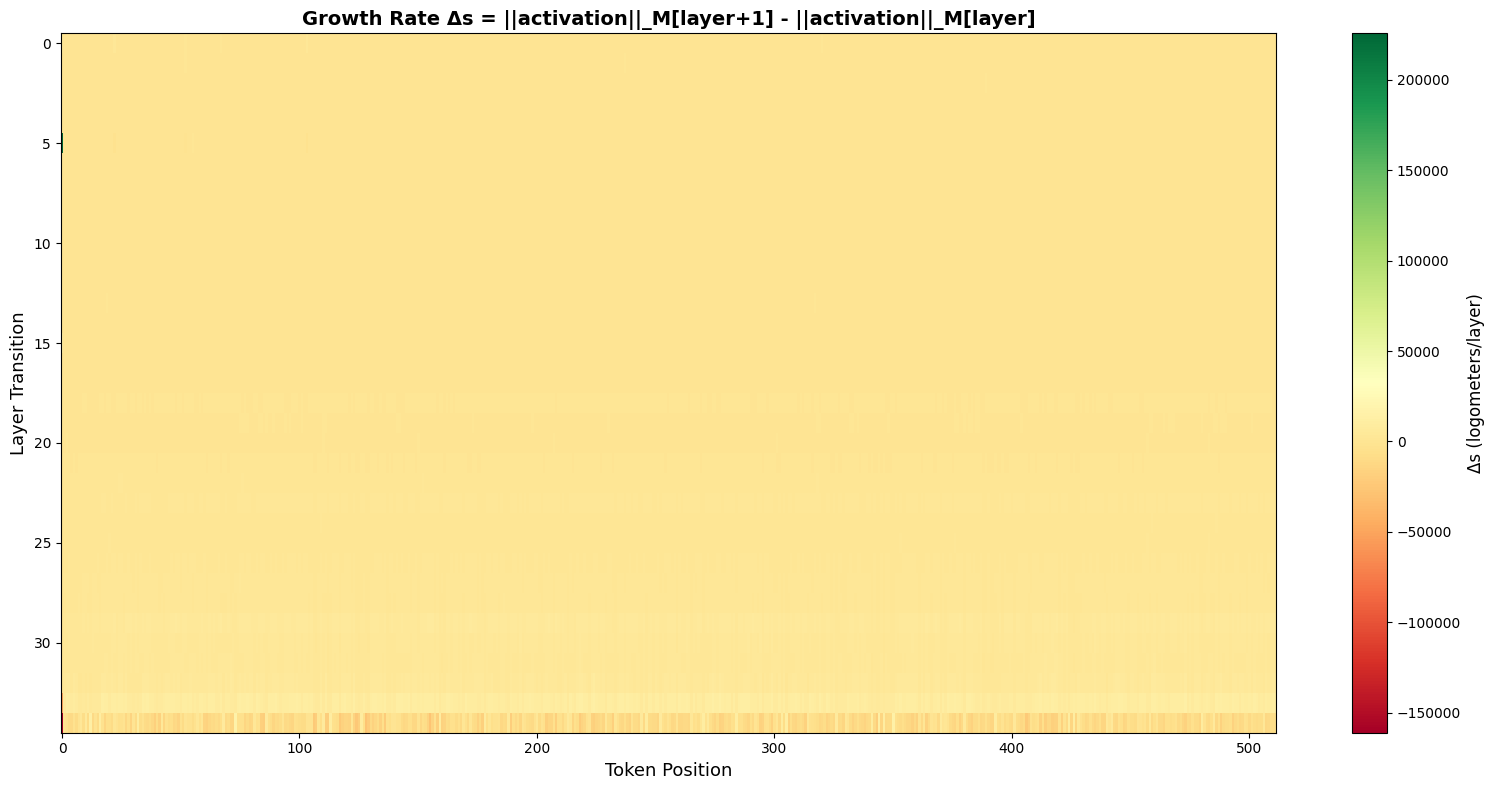

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))

im = ax.imshow(
    delta_norms,
    aspect='auto',
    cmap='RdYlGn',
    interpolation='nearest',
    vmin=delta_norms.min(),
    vmax=delta_norms.max(),
)

ax.set_xlabel('Token Position', fontsize=13)
ax.set_ylabel('Layer Transition', fontsize=13)
ax.set_title('Growth Rate Δs = ||activation||_M[layer+1] - ||activation||_M[layer]', fontsize=14, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Δs (logometers/layer)', fontsize=12)

plt.tight_layout()
plt.show()

## Visualization 3: Aggregate Statistics by Layer

**Panel A:** Mean causal norm vs layer (with ±1 std)  
**Panel B:** Mean Δs vs layer transition  

**What to look for:**
- Panel A: Overall expansion trend (compare to steering vector growth 23 → 3335)
- Panel B: Does growth accelerate (increasing Δs) or stay constant?

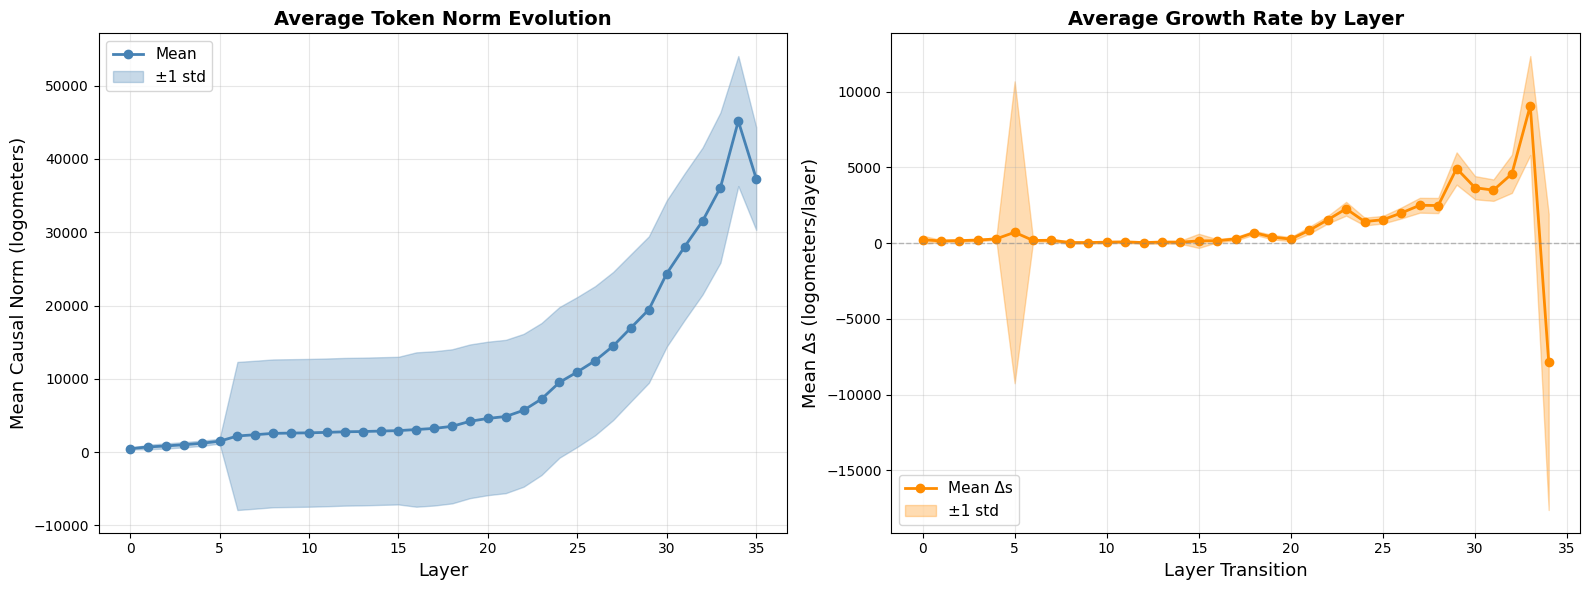

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Mean norm by layer
ax = axes[0]
mean_norms = causal_norms.mean(axis=1)
std_norms = causal_norms.std(axis=1)

ax.plot(range(n_layers), mean_norms, 'o-', linewidth=2, markersize=6, color='steelblue', label='Mean')
ax.fill_between(
    range(n_layers),
    mean_norms - std_norms,
    mean_norms + std_norms,
    alpha=0.3,
    color='steelblue',
    label='±1 std',
)
ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Mean Causal Norm (logometers)', fontsize=13)
ax.set_title('Average Token Norm Evolution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Panel B: Mean Δs by layer transition
ax = axes[1]
mean_deltas = delta_norms.mean(axis=1)
std_deltas = delta_norms.std(axis=1)

ax.plot(range(n_layers-1), mean_deltas, 'o-', linewidth=2, markersize=6, color='darkorange', label='Mean Δs')
ax.fill_between(
    range(n_layers-1),
    mean_deltas - std_deltas,
    mean_deltas + std_deltas,
    alpha=0.3,
    color='darkorange',
    label='±1 std',
)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Layer Transition', fontsize=13)
ax.set_ylabel('Mean Δs (logometers/layer)', fontsize=13)
ax.set_title('Average Growth Rate by Layer', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 4: Sample Token Trajectories

Pick 10 random tokens and plot their individual norm vs layer curves.

**What to look for:**
- Do all tokens follow similar curves?
- Do some explode while others stay flat?
- Is there diversity or uniformity?

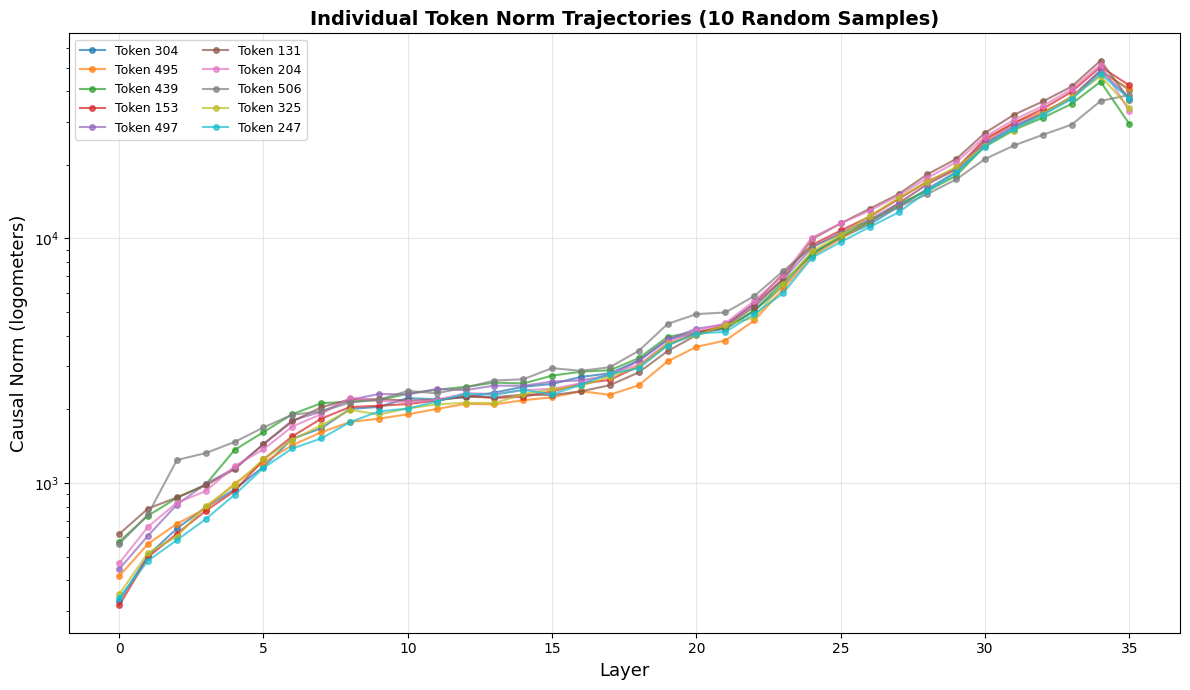

In [28]:
fig, ax = plt.subplots(figsize=(12, 7))

# Sample 10 random token indices
np.random.seed(42)
sample_indices = np.random.choice(n_tokens, size=min(10, n_tokens), replace=False)

# Plot each token's trajectory
for idx in sample_indices:
    ax.plot(
        range(n_layers),
        causal_norms[:, idx],
        'o-',
        linewidth=1.5,
        markersize=4,
        alpha=0.7,
        label=f'Token {idx}',
    )

ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Causal Norm (logometers)', fontsize=13)
ax.set_yscale('log')
ax.set_title('Individual Token Norm Trajectories (10 Random Samples)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 5: Δs Distribution by Layer

Box plots showing distribution of Δs at each layer transition.

**What to look for:**
- Does variability increase through layers (tokens diverge)?
- Or stay constant (uniform stretching)?
- Are there outliers (tokens with anomalous growth)?

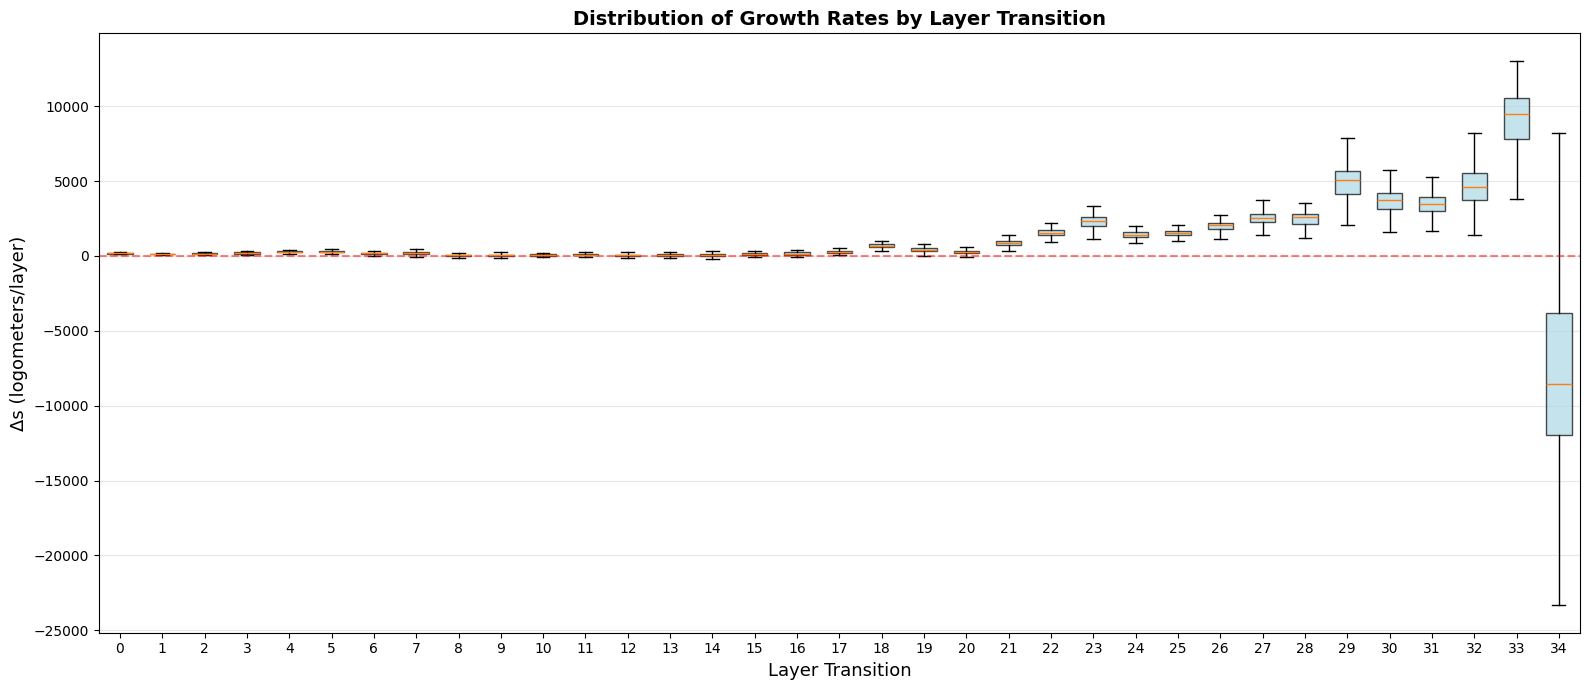

In [29]:
fig, ax = plt.subplots(figsize=(16, 7))

# Create box plot data
box_data = [delta_norms[i, :] for i in range(n_layers-1)]

bp = ax.boxplot(
    box_data,
    positions=range(n_layers-1),
    widths=0.6,
    patch_artist=True,
    showfliers=False,  # Hide outliers for cleaner visualization
)

# Color boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax.set_xlabel('Layer Transition', fontsize=13)
ax.set_ylabel('Δs (logometers/layer)', fontsize=13)
ax.set_title('Distribution of Growth Rates by Layer Transition', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Analysis: Uniform vs. Heterogeneous Expansion

Quantify whether expansion is uniform across tokens.

In [30]:
print("="*70)
print("EXPANSION UNIFORMITY ANALYSIS")
print("="*70)

# Compute coefficient of variation for Δs at each layer
cv_by_layer = delta_norms.std(axis=1) / np.abs(delta_norms.mean(axis=1))

print(f"\nCoefficient of Variation (CV) for Δs by layer:")
print(f"  Mean CV: {cv_by_layer.mean():.2f}")
print(f"  Range: [{cv_by_layer.min():.2f}, {cv_by_layer.max():.2f}]")

if cv_by_layer.mean() < 0.3:
    print("\n✓ LOW VARIABILITY → Expansion is UNIFORM across tokens")
    print("  Tokens stretch together at similar rates")
elif cv_by_layer.mean() > 0.7:
    print("\n→ HIGH VARIABILITY → Expansion is HETEROGENEOUS")
    print("  Different tokens experience very different growth rates")
else:
    print("\n→ MODERATE VARIABILITY → Mixed behavior")
    print("  Some uniformity but with token-specific variations")

# Check for position dependence (correlation between token position and average Δs)
avg_delta_per_token = delta_norms.mean(axis=0)  # Average Δs across all layers for each token
token_positions = np.arange(n_tokens)
position_correlation = np.corrcoef(token_positions, avg_delta_per_token)[0, 1]

print(f"\nPosition dependence:")
print(f"  Correlation(position, avg_Δs): {position_correlation:.3f}")

if abs(position_correlation) > 0.5:
    print(f"  → STRONG position dependence (early/late tokens differ)")
elif abs(position_correlation) > 0.2:
    print(f"  → MODERATE position dependence")
else:
    print(f"  → No significant position dependence")

# Check if expansion accelerates
mean_deltas_by_layer = delta_norms.mean(axis=1)
acceleration = np.diff(mean_deltas_by_layer)  # Second derivative

print(f"\nExpansion acceleration:")
print(f"  Mean second derivative: {acceleration.mean():.2f}")
positive_accel = (acceleration > 0).sum()
total_transitions = len(acceleration)
print(f"  Positive acceleration: {positive_accel}/{total_transitions} transitions ({100*positive_accel/total_transitions:.1f}%)")

if positive_accel / total_transitions > 0.6:
    print("  → Expansion ACCELERATES through layers")
elif positive_accel / total_transitions < 0.4:
    print("  → Expansion DECELERATES through layers")
else:
    print("  → Expansion rate is roughly CONSTANT")

print("\n" + "="*70)

EXPANSION UNIFORMITY ANALYSIS

Coefficient of Variation (CV) for Δs by layer:
  Mean CV: 1.12
  Range: [0.16, 13.95]

→ HIGH VARIABILITY → Expansion is HETEROGENEOUS
  Different tokens experience very different growth rates

Position dependence:
  Correlation(position, avg_Δs): 0.065
  → No significant position dependence

Expansion acceleration:
  Mean second derivative: -237.16
  Positive acceleration: 21/34 transitions (61.8%)
  → Expansion ACCELERATES through layers



## Summary

**Key findings:**
1. Overall norm range: X - Y logometers
2. Growth pattern: monotonic / mixed / with shrinkage
3. Uniformity: uniform / heterogeneous / position-dependent
4. Acceleration: constant / accelerating / decelerating

**Interpretation:**
- Compare mean norm growth to steering vector growth (23 → 3335)
- Does this explain manifold expansion through layers?
- Are there critical layers where geometry changes?

**Next steps:**
- If patterns are clear: expand to multiple texts, analyze by token type
- If too noisy: stick with layer-averaged metrics (steering vectors)
- Compare to norm evolution DURING steering (does intervention change patterns?)